In [1]:
import sys
sys.path.append('../..')
import json
import numpy as np
from os.path import join
import matplotlib.pyplot as plt

# PyTorch
import torch.nn as nn
from torch import cuda
from torchvision.models.mobilenet import mobilenet_v2

# DLBio
from DLBio import pt_training
from DLBio.helpers import check_mkdir
from DLBio.pt_train_printer import Printer
from DLBio.pytorch_helpers import get_device, get_num_params

# own scripts
import ds_ear
from classification_test import TestMyModel

In [2]:
class Classification(pt_training.ITrainInterface):
    def __init__(self, model, device):
        self.model = model
        self.xent_loss = nn.CrossEntropyLoss()
        self.metrics = {
            'acc': accuracy
        }
        self.d = device

    def train_step(self, sample):
        images, targets = sample[0].to(self.d), sample[1].to(self.d)
        pred = self.model(images)

        loss = self.xent_loss(pred, targets)
        metrics = dict()

        metrics.update({k: v(pred, targets) for k, v in self.metrics.items()})

        return loss, metrics


def accuracy(y_pred, y_true):
    _, y_pred = y_pred.max(1)  # grab class predictions
    return (y_pred == y_true).float().mean().item()

In [3]:

class Config():
    # influences learning rate, weight decay, data folder path and training classes
    IS_OWN_DATASET = True
    # define constants
    LEARNING_RATE = (0.001, 0.01)[IS_OWN_DATASET] # FORM: (AMI, dataset)
    WEIGHT_DECAY = (0.0001, 0.001)[IS_OWN_DATASET] # FORM: (AMI, dataset)
    DATASET_DIR = ('../AMI', '../dataset')[IS_OWN_DATASET]
    # grab dataset for length and classes
    dset = ds_ear.get_dataset(data_path=DATASET_DIR, transform_mode='size_only')
    CLASSES = len(dset.classes)
    
    BATCH_SIZE = 32
    NUM_WORKERS = 3
    EPOCHS = 15

    FOLDER = './class_sample'
    OPT_TYPE = 'Adam'
    LR_STEPS = 3
    DO_EARLY_STOPPING = True
    STOP_AFTER = 10
    ES_METRIC = 'val_acc'
    SAVE_INTERVALL = -1
    PRINT_FREQUENCY = 500 # print every 500 batches
    SEED = 0

# use seeds to ensure comparable results ()
# pt_training.set_random_seed(SEED)
# np.random.seed(SEED)

model = mobilenet_v2(pretrained=True)
fir = model.features[0][0]
# Swap between grey and color
model.features[0][0] = nn.Conv2d(
                        in_channels=1,
                        out_channels=fir.out_channels,
                        kernel_size=fir.kernel_size,
                        stride=fir.stride,
                        padding=fir.padding,
                        bias=fir.bias
                        )
# Remap the classification layer to the correct amount of classes
model.classifier[1] = nn.Linear(in_features=model.classifier[1].in_features, out_features=Config.CLASSES)


In [4]:
#freezes all mobilenet parameters except classifier
for param in model.features.parameters():
    param.requires_grad = False

from DLBio.pytorch_helpers import get_num_params
get_num_params(model,True)

60207

In [ ]:
# #To Define which Layers we want to train
# feature_layers = list(model.features.children())
# unfreezed = [18]
# for u in unfreezed:
#     for param in feature_layers[u].parameters():
#         param.requires_grad = True


In [ ]:
from DLBio.pytorch_helpers import get_num_params
get_num_params(model,True)

In [5]:
device = get_device()
# device = 'cpu'
print(device)
model.to(device)

# define folder to save model and log file
check_mkdir(Config.FOLDER, is_dir=True)
model_out = join(Config.FOLDER, 'model.pt')
log_file = join(Config.FOLDER, 'log.json')

cuda:0


In [6]:
# define indicies to split Data
N = len(Config.dset)
print(N)

# List of index where classes switch
class_switch = [0]
for c in range(Config.CLASSES):
    for i,(_, class_idx) in enumerate(Config.dset.imgs):
        if class_idx > c:
            # append current index of class switch
            class_switch.append(i)
            break
# append last index
class_switch.append(len(Config.dset.imgs)-1)

train_indices, valid_indices, test_indices = [],[],[]
# go through all classes
for i in range(len(class_switch)-1):
    # lists the indices of each class
    rand_class = np.random.permutation(list(range(class_switch[i], class_switch[i+1])))
    length = len(rand_class)
    # calculate percentage of current classes
    n_80 = int(round(.8*length))
    n_70 = int(round(.7*length))
    n_60 = int(round(.6*length))
    n_20 = int(round(.2*length))
    n_10 = int(round(.1*length))
    # add percentage of indices to respective lists
    train_indices.extend(rand_class[:n_70])
    valid_indices.extend(rand_class[n_70:n_70+n_20])
    test_indices.extend(rand_class[n_70+n_20:])

3760


In [12]:
# write some model specs
with open(join(Config.FOLDER, 'model_specs.json'), 'w') as file:
    json.dump({
        'num_trainable': float(get_num_params(model, True)),
        'num_params': float(get_num_params(model, False))
    }, file)

# definde data loader
dl_train = ds_ear.get_dataloader(
    data_path=Config.DATASET_DIR,
    indices=train_indices,
    batch_size=Config.BATCH_SIZE,
    num_workers=Config.NUM_WORKERS,
    transform_mode='train_gray'
)

dl_valid = ds_ear.get_dataloader(
    data_path=Config.DATASET_DIR,
    indices=valid_indices,
    batch_size=Config.BATCH_SIZE,
    num_workers=Config.NUM_WORKERS,
    transform_mode='valid_and_test'
)

dl_test = ds_ear.get_dataloader(
    data_path=Config.DATASET_DIR,
    indices=test_indices,
    batch_size=Config.BATCH_SIZE,
    num_workers=Config.NUM_WORKERS,
    transform_mode='valid_and_test'
)

print(dl_train.dataset.classes, '\n', len(dl_train.dataset.classes), ' classes')

# with open('test_indizes.txt', 'w') as file:
#     for idx in test_indices:
#         file.write("%i\n" % idx)

['alexander_bec', 'alina_sch', 'alissa_buh', 'amanda_dab', 'anna_kab', 'anni_qua', 'beatrix_mah', 'clara_pau', 'clemens_blu', 'collin_sch', 'david_fau', 'falco_len', 'felix_mec', 'gregor_spi', 'hammam_als', 'janna_qua', 'janole_pen', 'jesse_kru', 'johannes_wie', 'jule_dre', 'julia_fis', 'konrad_von', 'lars_fin', 'linus_fal', 'lynn_man', 'maike_her', 'malte_gas', 'marcel_nim', 'marcus_jue', 'marejke_wen', 'marina_fri', 'marina_han', 'matilda_kni', 'meiko_pri', 'mila_wol', 'mohammed_muh', 'moritz_bor', 'moritz_mei', 'nils_loo', 'pauline_bus', 'robert_kle', 'robert_sch', 'sarah_amo', 'sarah_feh', 'sina_jun', 'tim_moe', 'yannik_obe'] 
 47  classes


In [13]:
# define optimizer
optimizer = pt_training.get_optimizer(
        'Adam', model.parameters(),
        Config.LEARNING_RATE,
        weight_decay=Config.WEIGHT_DECAY
    )

if Config.LR_STEPS > 0:
    scheduler = pt_training.get_scheduler(
            Config.LR_STEPS, Config.EPOCHS, optimizer)

if Config.DO_EARLY_STOPPING:
    assert Config.SAVE_INTERVALL == -1
    early_stopping = pt_training.EarlyStopping(
            Config.ES_METRIC, get_max=True, epoch_thres=Config.STOP_AFTER
        )
else:
    early_stopping = None
    
train_interface = Classification(model, device)

training = pt_training.Training(
        optimizer, dl_train, train_interface,
        scheduler=scheduler, printer=Printer(Config.PRINT_FREQUENCY, log_file),
        save_path=model_out, save_steps=Config.SAVE_INTERVALL,
        val_data_loader=dl_valid,
        early_stopping=early_stopping
    )

training(Config.EPOCHS)

Sched step size: 5
Ep: 0, loss: 1.28989 acc: 0.717 lr: 0.01000 sec: 9.44
saving model: ./class_sample/model.pt
Ep: 0, val_loss: 0.98246 val_acc: 0.771 lr: -1.00000 sec: 2.91
Ep: 1, loss: 1.03528 acc: 0.745 lr: 0.01000 sec: 9.39
saving model: ./class_sample/model.pt
Ep: 1, val_loss: 0.65277 val_acc: 0.822 lr: -1.00000 sec: 2.96
Ep: 2, loss: 1.01764 acc: 0.747 lr: 0.01000 sec: 9.30
Ep: 2, val_loss: 0.84824 val_acc: 0.815 lr: -1.00000 sec: 2.86
Ep: 3, loss: 0.88954 acc: 0.791 lr: 0.01000 sec: 9.11
Ep: 3, val_loss: 0.67238 val_acc: 0.820 lr: -1.00000 sec: 2.87
Ep: 4, loss: 0.87126 acc: 0.790 lr: 0.01000 sec: 9.20
saving model: ./class_sample/model.pt
Ep: 4, val_loss: 0.67194 val_acc: 0.832 lr: -1.00000 sec: 2.82
Ep: 5, loss: 0.39307 acc: 0.891 lr: 0.00100 sec: 9.27
saving model: ./class_sample/model.pt
Ep: 5, val_loss: 0.25351 val_acc: 0.921 lr: -1.00000 sec: 2.93
Ep: 6, loss: 0.29763 acc: 0.915 lr: 0.00100 sec: 9.25
saving model: ./class_sample/model.pt
Ep: 6, val_loss: 0.17428 val_acc: 0

In [9]:
print("L Rate:\t", Config.LEARNING_RATE)
print("W Dcay:\t", Config.WEIGHT_DECAY)
print("Clas:\t", Config.CLASSES)
print("Batch:\t", Config.BATCH_SIZE)
print("Epochs:\t", Config.EPOCHS)

L Rate:	 0.01
W Dcay:	 0.001
Clas:	 47
Batch:	 32
Epochs:	 15


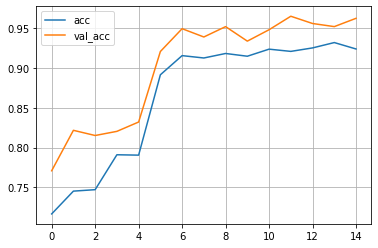

In [14]:
with open(log_file, 'r') as file:
    log = json.load(file)

plt.plot(log['acc'], label='acc')
plt.plot(log['val_acc'], label='val_acc')
plt.legend()
plt.grid()

In [ ]:
# # Execute this cell if you want the current variables to be added to the csv-file
# import csv

# with open(log_file, 'r') as file:
#     log = json.load(file)
#     ACC = log['acc']
#     VAL_ACC = log['val_acc']

# with open('var_log.csv', 'a') as f:
#     writer = csv.writer(f, delimiter=',', lineterminator='\n')
#     writer.writerow([
#         Config.DATASET_DIR.split('/')[1],        
#         Config.LEARNING_RATE,
#         Config.WEIGHT_DECAY,
#         Config.CLASSES,
#         Config.OPT_TYPE,
#         Config.EPOCHS,
#         Config.LR_STEPS,
#         Config.DO_EARLY_STOPPING,
#         Config.STOP_AFTER,
#         Config.SEED,
#         Config.BATCH_SIZE,
#         Config.NUM_WORKERS,
#         # saves a list of len(EPOCHS) with accuracies
#         ACC,
#         VAL_ACC,
#         # insert optional comment
#         ""
#     ])
# f.close()



In [11]:
test = TestMyModel(dl_test, Config.FOLDER)

test.load_model()
test.start_testing()
test.class_acc()

Index   Name                
0       model_specs.json    
1       model.pt            
2       log.json            
Loading  model.pt  ...

 Accuracy of the network : 95% 

Accuracy of   alexander_bec :  87.50 % 	   Number of images: 8
Accuracy of       alina_sch :  87.50 % 	   Number of images: 8
Accuracy of      alissa_buh : 100.00 % 	   Number of images: 8
Accuracy of      amanda_dab : 100.00 % 	   Number of images: 8
Accuracy of        anna_kab :  87.50 % 	   Number of images: 8
Accuracy of        anni_qua :  87.50 % 	   Number of images: 8
Accuracy of     beatrix_mah : 100.00 % 	   Number of images: 8
Accuracy of       clara_pau : 100.00 % 	   Number of images: 8
Accuracy of     clemens_blu : 100.00 % 	   Number of images: 8
Accuracy of      collin_sch :  75.00 % 	   Number of images: 8
Accuracy of       david_fau :  62.50 % 	   Number of images: 8
Accuracy of       falco_len : 100.00 % 	   Number of images: 8
Accuracy of       felix_mec : 100.00 % 	   Number of images: 8
Accuracy

In [ ]:
# model.classifier = nn.Sequential(*list(model.classifier.children())[:-2])
# model.eval()

In [ ]:
# import torch
# torch.save(model, './models/model_classification_MN_classifier_removed_85%.pt')